In [1]:
%load_ext autoreload
%autoreload 2

import os
from convvisual.theano import init_theano
init_theano(switch_cpu=True,debug=True)

import logging
log = logging.getLogger()
log.setLevel("DEBUG")
from braindecode.scripts.train_experiments import setup_logging
setup_logging()

/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import lasagne
import numpy as np
from braindecode.experiments.load import load_exp_and_model
from braindecode.veganlasagne.layer_util import print_layers
from braindecode.veganlasagne.layers import create_pred_fn
from convvisual.receptive_field.utils import check_if_finalreshape_is_needed,receptive_field_build_deconv_layers

In [3]:
subject = 22

In [4]:
modelpath = '/home/hartmank/braindecode/data/models/'
modelname = 'paper/ours/cnt/deep4/car/%d'%subject

In [5]:
exp, model = load_exp_and_model(os.path.join(modelpath,modelname),
                                set_invalid_to_NaN=False)
exp.dataset.load()

datasets = exp.dataset_provider.get_train_merged_valid_test(exp.dataset)
test_batches = list(exp.iterator.get_batches(datasets['train'], shuffle=False))
inputs,targets = test_batches[0]

2017-05-17 17:26:59,817 Setting n_sample preds automatically to 479
2017-05-17 17:26:59,819 Input window length is 522
2017-05-17 17:26:59,999 Setting n_sample preds automatically to 479
2017-05-17 17:27:00,001 Input window length is 522
2017-05-17 17:27:00,002 Load Training Set...
2017-05-17 17:27:29,912 Load Test Set...
2017-05-17 17:27:35,446 Clean Training Set...
2017-05-17 17:27:36,686 Rejected channels: []
2017-05-17 17:27:36,688 #Clean trials:     895
2017-05-17 17:27:36,688 #Rejected trials:  2
2017-05-17 17:27:36,689 Fraction Clean:    99.0%
2017-05-17 17:27:36,690 (from maxmin):     2
2017-05-17 17:27:36,690 (from var):        0
2017-05-17 17:27:37,019 Clean Test Set...
2017-05-17 17:27:37,233 Rejected channels: []
2017-05-17 17:27:37,234 #Clean trials:     160
2017-05-17 17:27:37,235 #Rejected trials:  0
2017-05-17 17:27:37,235 Fraction Clean:    100.0%
2017-05-17 17:27:37,236 (from maxmin):     0
2017-05-17 17:27:37,237 (from var):        0
2017-05-17 17:27:37,237 Create Cl

In [6]:
print_layers(model)

 0-InputLayer                                                         [None, 128, 1000, 1]
 1-DimshuffleLayer                                                    (None, 1, 1000, 128)
 2-DropoutLayer             0.000                                    
 3-Conv2DLayer              10x1                                      (None, 25, 991, 128)
 4-Conv2DAllColsLayer       1x128                                     (None, 25, 991, 1)
 5-BatchNormLayer                                     elu            
 6-Pool2DLayer              3x1                       max             (None, 25, 989, 1)
 7-StrideReshapeLayer           ::3 ::1                               (None, 25, 330, 1)
 8-NonlinearityLayer                                                 
 9-DropoutLayer             0.500                                    
10-Conv2DLayer              10x1                                      (None, 50, 321, 1)
11-BatchNormLayer                                     elu            
12-Pool2DLayer       

In [74]:
extract_layers = [0,3,4,10,16,22]#,28]
extract_reshapes = [0,0,0,3,9,27]#,81]
extract_models_out = list()
extract_models = list()
extract_fns = list()
model = lasagne.layers.get_all_layers(model)
for i,l in enumerate(extract_layers):
    if i==0:
        continue
        
    #model_tmp,layer_tmp = check_if_finalreshape_is_needed(model,l)
    model_RF = receptive_field_build_deconv_layers(model[l],
        model[extract_layers[i-1]+1],
        use_learned_W=False,
        X_reshape=extract_reshapes[i],n_filters=1)
    
    extract_models.append(lasagne.layers.get_all_layers(model_RF))
    extract_models_out.append(model[l])
extract_models = np.asarray(extract_models)

In [75]:
extract_fns = list()

model_tmp = np.asarray(lasagne.layers.get_all_layers(model))
pred_fn = create_pred_fn(extract_models_out)
for m in extract_models:
    extract_fns.append(create_pred_fn(m[-1]))

In [76]:
outputs = pred_fn(inputs)

In [78]:
prev_out = np.ones(outputs[-1].shape)[:,[0],:,:]

for i,l in reversed(list(enumerate(extract_layers))):
    if i is not 0:
        print i
        l_out = np.abs(outputs[i-1]).mean(axis=1)
        l_out = np.expand_dims(l_out,1)
        print l_out.shape,prev_out.shape
        l_out *= prev_out
        prev_out = extract_fns[i-1](l_out)

5
(1620, 1, 23, 1) (1620, 1, 23, 1)
4
(540, 1, 98, 1) (540, 1, 98, 1)
3
(180, 1, 321, 1) (180, 1, 321, 1)
2
(60, 1, 991, 1) (60, 1, 991, 1)
1
(60, 1, 991, 128) (60, 1, 991, 128)


In [79]:
salient_mask = prev_out-prev_out.min()
salient_mask /= salient_mask.max()

In [80]:
import matplotlib.pyplot as plt

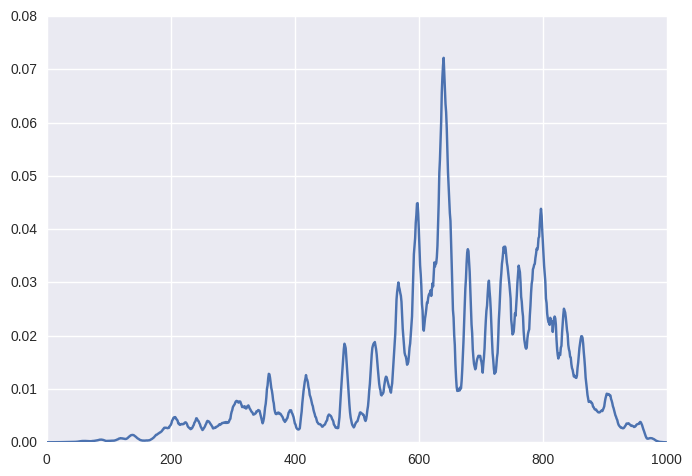

In [93]:
plt.plot(salient_mask[0,53,:,0])
plt.show()

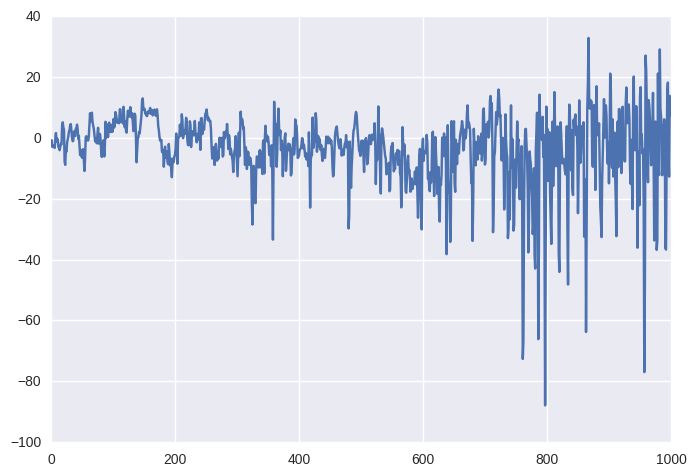

In [94]:
plt.plot(inputs[0,53,:,0])
plt.show()

In [92]:
np.unravel_index(salient_mask[0,:,:,0].argmax(),salient_mask[0,:,:,0].shape)

(53, 640)